In [1]:
epochs = 5
batch_size = 128
lr = 1e-3

In [2]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 784)).astype(np.float32) / 255 
x_test = x_test.reshape((-1, 784)).astype(np.float32) / 255
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [3]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [4]:
x = tf.placeholder(tf.float32, (None,784)) 
y = tf.placeholder(tf.int32, (None,)) 

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

b1 = tf.get_variable('b1', (512,), tf.float32, init_b)
w1 = tf.get_variable('w1', (784,512), tf.float32, init_w)

b2 = tf.get_variable('b2', (10,), tf.float32, init_b)
w2 = tf.get_variable('w2', (512,10), tf.float32, init_w)

x1 = tf.nn.relu(x @ w1 + b1) 
logits = x1 @ w2 + b2 
y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [6]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, y_pred], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/5 
epoch 1/5 
epoch 2/5 
epoch 3/5 
epoch 4/5 

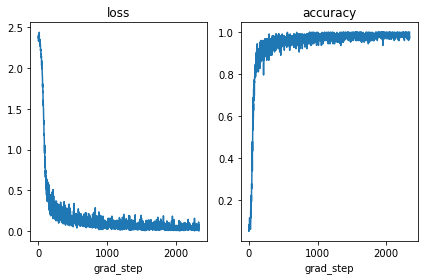

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [8]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.9803


In [9]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[ 968    0    0    1    0    1    5    1    3    1]
 [   0 1128    2    1    0    0    2    0    2    0]
 [   6    3  997    4    2    0    3    4   13    0]
 [   1    0    1  996    1    0    0    4    5    2]
 [   2    0    2    1  963    0    3    3    0    8]
 [   3    0    0   10    1  860    6    1    8    3]
 [   3    3    1    1    3    2  941    1    3    0]
 [   1    4    6    4    0    0    0 1007    2    4]
 [   0    0    2    4    2    0    2    2  959    3]
 [   1    2    0    4    7    2    1    4    4  984]]


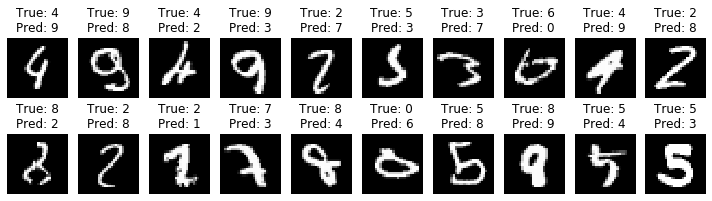

In [10]:
fig, axes = plt.subplots(2, 10, figsize=(10,3))
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test[idx]==y_test_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.gray)
            ax.set_title('True: {}\nPred: {}'.format(y_test[idx], y_test_pred[idx]))
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()